# This is a test for 3D Reconstruction

In [1515]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import IO as io
import re
import scipy.ndimage as ndimage

%matplotlib inline

## Reading Images

In [1516]:
idx = '1'
directory = 'Stereo_SD_d_all/Stereo_SD_d_all_{}/'.format(idx)
result = 'Stereo_SD_d_all_result/Stereo_SD_d_all_{}_result.{}'

There is no need to read the images from top.

In [1517]:
image = 'Stereo_SD_d_all_{}_IMG_REC_{}.bmp'
left = plt.imread(directory+image.format(idx, 'left'))
right = plt.imread(directory+image.format(idx, 'right'))

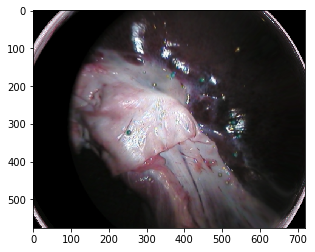

In [1518]:
plt.imshow(left)

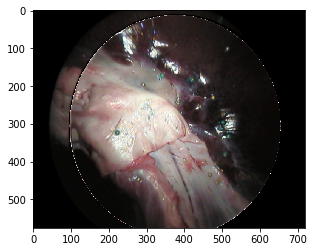

In [1519]:
plt.imshow(right)

## Calculating the disparity map using OpenCV

If `P1` and `P2` are set to `1000` and `10000` respectively, then the result would be smoother. 

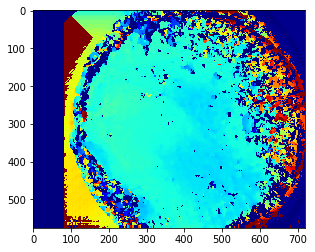

In [1520]:
stereo = cv.StereoSGBM_create(
    numDisparities=80,
    blockSize=11,
#     P1=1000,
#     P2=10000,
)

disp = stereo.compute(
    left,
    right,
)/(16)

plt.imshow(disp, cmap='jet')

## 3D Reconstruction

### Reading mask

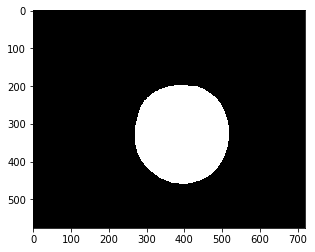

In [1521]:
# !ls Stereo_SD_d_all/Stereo_SD_d_all_1/
mask = 'Stereo_SD_d_all_{}_MASK_REC_eval.png'.format(idx)
mask = plt.imread(directory+mask)
plt.imshow(mask, cmap='binary')

### Reading Calibration

Apparently, the socond set of calibration parameters are for the left camera.

Also, using $f_y$, instead of $f_x$ as $f$ works better.

Base line should be $4mm$ (`4`). So the result output would also be in `mm`.

In [1522]:
cal_regex = re.compile(r"(?P<width>\d+).0{10}\s{2}(?P<height>\d+).0{10}\s{2}(?P<fx>\d+.\d{10})[\s0.]+(?P<cx>\d+.\d{10})[\s0.]+(?P<fy>\d+.\d{10})\s{2}(?P<cy>\d+.\d{10})", re.I)

calibration = open(directory+'Stereo_SD_d_all_{}_Calibration.txt'.format(idx))
calibrations = [m.groupdict() for m in cal_regex.finditer(calibration.read())]

for i in range(0,2):
    for key in calibrations[i]:
        calibrations[i][key] = np.float64(calibrations[i][key])
    
calibrations

[{'cx': 329.4085998535,
  'cy': 308.6358642578,
  'fx': 439.1244812012,
  'fy': 468.655670166,
  'height': 576.0,
  'width': 720.0},
 {'cx': 375.9163208008,
  'cy': 302.8897399902,
  'fx': 433.9014892578,
  'fy': 463.8944091797,
  'height': 576.0,
  'width': 720.0}]

#### Q matrix

In [1523]:
baseline = 4
q = np.float32([
    [1, 0, 0, -calibrations[1]['cx']],
    [0, 1, 0, -calibrations[1]['cy']],
    [0, 0, 0, calibrations[1]['fy']],
    [0, 0, -1/baseline, 0]
])
q

array([[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00, -3.7591632e+02],
       [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, -3.0288974e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  4.6389441e+02],
       [ 0.0000000e+00,  0.0000000e+00, -2.5000000e-01,  0.0000000e+00]],
      dtype=float32)

combinig all coordinates and colos together.

It would be like $[x_2, y_2, x_3, y_3, z_3, R, G, B]$

In [1524]:
point_cloud = cv.reprojectImageTo3D(np.float32(disp), q)
colored_point_cloud = np.hstack([np.argwhere(mask == 0), (-1*point_cloud[mask==0]), left[mask==0]])

#### Remove Outliers

The target points are between $0$ to $100$ in depth. First we will get rid of any point outside this range, then calculate the `mean` and `std` of the remaining.

Assuming that the remaining points have a Normal Distribution, we only keep anything within two `std` of the mean.

Here is an histogram of this region.

66.17225293784699 3.2799192880100434 72.73209151386708 59.61241436182691


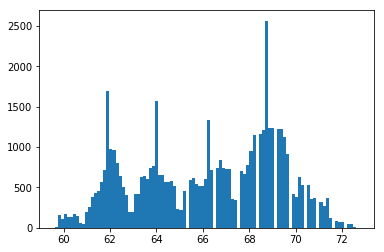

In [1531]:
x = colored_point_cloud[:, 4]  # 4 => Z
x = x[x < 100]
x = x[x > 0]

mean = np.mean(x)
std = np.std(x)

up = mean+2*std
down = mean-2*std

print(mean, std, up, down)

x = x[x < up]
x = x[x > down]
n, bins, patches = plt.hist(x, 100, range=(down, up))
plt.show()

In [1526]:
c = colored_point_cloud
c = c[ (c[:, 4] < up) & (c[:, 4] > down) ]  # 4 => Z
c

array([[198.        , 386.        ,   1.48017311, ..., 136.        ,
        124.        , 135.        ],
       [198.        , 387.        ,   1.61953306, ..., 136.        ,
        121.        , 132.        ],
       [198.        , 388.        ,   1.76162982, ..., 137.        ,
        117.        , 130.        ],
       ...,
       [458.        , 408.        ,   4.68802595, ..., 126.        ,
        115.        , 125.        ],
       [458.        , 409.        ,   4.83414507, ..., 127.        ,
        118.        , 126.        ],
       [458.        , 410.        ,   4.99166012, ..., 127.        ,
        120.        , 127.        ]])

#### Create Ply File

Saving `ply` format. 

In [1527]:
def create_ply(vertices, filename):
    vertices = vertices.reshape(-1, 8)[:, 2:]
    vertices[:, [0, 1, 2, 3, 4, 5]] = vertices[:, [1, 0, 2, 3, 4, 5]]  # Swapping Columns

    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
    with open(filename, 'w') as f:
        f.write(ply_header % dict(vert_num=len(vertices)))
        np.savetxt(f, vertices, '%f %f %f %d %d %d')

In [1528]:
create_ply(
    vertices=c,
    filename=result.format(idx, 'ply')
)

Saving `xyz` Format.

In [1529]:
def create_xyz(vertices, filename):
    vertices = vertices.reshape(-1, 8)[:, 0:5]
    vertices[:, [0, 1, 2, 3, 4]] = vertices[:, [1, 0, 3, 2, 4]]  # Swapping Columns

    with open(filename, 'w') as f:
        np.savetxt(f, vertices, '%d %d %f %f %f')

In [1530]:
create_xyz(
    vertices=c, 
    filename=result.format(idx, 'xyz')
)